In [1]:
#This notebook creates Figures 6&8 from Reichl et al., 2024 submitted to ESS

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
from glob import glob
import sys
import gsw as gsw
import copy as copy
import matplotlib as mpl
def modtime(H):
    try:
        datetimeindex = H.indexes['Time'].to_datetimeindex()
        H['Time']=datetimeindex
    except:
        datetimeindex = H.indexes['time'].to_datetimeindex()
        H['time']=datetimeindex
        
    return H

In [2]:
#This should point to where LES and SCM data are located.
data_loc = '/net/bgr/Work/Tropics_Paper/Paper/Data'
LES0 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))
LES3 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_3N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))

LES0_1h = LES0.resample(time='1H').interpolate(kind="linear")
LES3_1h = LES3.resample(time='1H').interpolate(kind="linear")


/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to 

In [3]:
mom_data_loc = '/net2/bgr/Manuscripts/Tropics/Data'

MOM0 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_ePBL_RH18_0.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())
MOM3 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_ePBL_RH18_3.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())

MOM0_1 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_ePBL_cap_0.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())
MOM3_1 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_ePBL_cap_3.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())

MOM0_2 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_GLS_0.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())
MOM3_2 = modtime(xr.open_dataset(mom_data_loc+'/19851002.ocean_hourly_GLS_3.nc').isel(xh=0,yh=0,xq=0,yq=0).squeeze())

for MOM in [MOM0,MOM3,MOM0_1,MOM3_1,MOM0_2,MOM3_2]:
    MOM['N2']=(('time','zl'),(MOM.rhopot0.differentiate(coord='zl')).values.squeeze()*9.81/1025)
    MOM['S2']=(('time','zl'),(MOM.uo.differentiate(coord='zl')**2).values.squeeze()+(MOM.vo.differentiate(coord='zl')**2).values.squeeze())
    



/tmp/ipykernel_2404034/1457887283.py:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()
/tmp/ipykernel_2404034/1457887283.py:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()
/tmp/ipykernel_2404034/1457887283.py:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time betwe

In [4]:
def group_by_hour(data1h,detrend=False):
    #Deals with the fact that the dataset might not
    # be divisible by 24 hours, in which case the
    # composites are sensitive to averaging over the
    # samples while forcing changes over the dataset.
    #We simply cut the last indices out that do not give a full day.
    LT = np.shape(data1h)[0]
    LZ = np.shape(data1h)[1]
    
    FLD=np.zeros([24,LZ])
    FLDdt=np.zeros([24,LZ])

    for ii in range(24):
        UP = (LT//24)*24
        HRs = data1h[ii:UP:24,:]
        FLD[ii,:]=np.mean(HRs,axis=0)

    if detrend:
        #Removes the trend
        for ii in range(LZ):
            FLDdt[:,ii]=FLD[:,ii]-np.arange(0.5,24)*(FLD[-1,ii]-FLD[0,ii])/24
        return FLDdt
    else:
        return FLD
def group_by_hour_1d(data1h):
    LT = len(data1h)
    
    FLD=np.zeros(LT)
    
    for ii in range(24):
        UP = (LT//24)*24
        HRs = data1h[ii:UP:24]
        FLD[ii]=np.mean(HRs,axis=0)
    return FLD



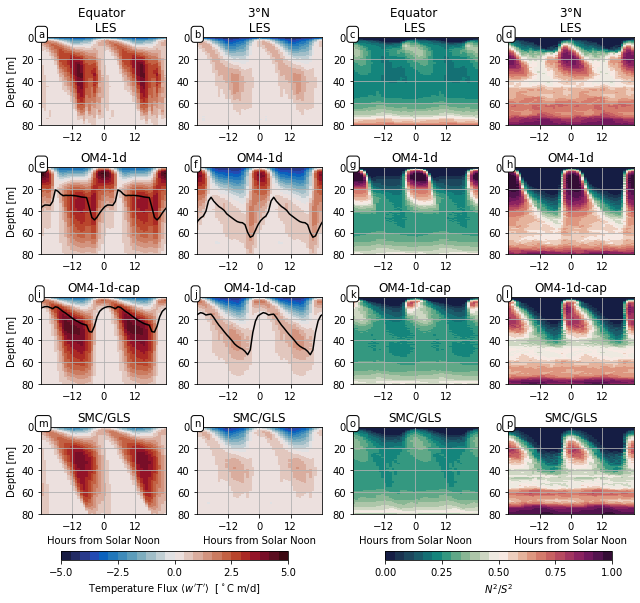

In [5]:
cmap1=cmocean.cm.curl
levels1=np.linspace(0,1,25)

cmap2=cmocean.cm.balance
levels2=np.linspace(-5,5,25)

#Setting time axis w/ zero referenced to (local) solar Noon
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)

f,a=plt.subplots(4,4,figsize=(9,8))

LES_DAT=(-LES0_1h.tempw+LES0_1h.kappadtdz).values.astype(np.float64)*86400
FLDdt = group_by_hour(LES_DAT)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[0]
C1=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap2,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('Equator \n LES')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[4]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
BLD = group_by_hour_1d(MOM0.ePBL_h_ML.values)
ax.plot(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),np.concatenate((BLD[xi],BLD[xi],BLD[xi])),'k-')
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0_1.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[8]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
BLD = group_by_hour_1d(MOM0_1.ePBL_h_ML.values)
ax.plot(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),np.concatenate((BLD[xi],BLD[xi],BLD[xi])),'k-')
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0_2.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[12]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hours from Solar Noon')

LES_DAT=(-LES3_1h.tempw+LES3_1h.kappadtdz).values.astype(np.float64)*86400
FLDdt = group_by_hour(LES_DAT)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[1]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES3_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap2,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('3$\degree$N \n LES ')

FLDdt = group_by_hour(MOM3.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[5]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
BLD = group_by_hour_1d(MOM3.ePBL_h_ML.values)
ax.plot(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),np.concatenate((BLD[xi],BLD[xi],BLD[xi])),'k-')
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')

FLDdt = group_by_hour(MOM3_1.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[9]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_1.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
BLD = group_by_hour_1d(MOM3_1.ePBL_h_ML.values)
ax.plot(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),np.concatenate((BLD[xi],BLD[xi],BLD[xi])),'k-')
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')

FLDdt = group_by_hour(MOM3_2.Tflx_dia_diff.values.astype(np.float64))*86400
fld=(FLDdt[xi,:]).T
ax=a.ravel()[13]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_2.zi,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
ax.set_xlabel('Hours from Solar Noon')

#Capping Ri so means aren't skewed
LES_DAT=np.maximum(0,np.minimum(1.,(LES0_1h.N2/LES0_1h.S2).values.astype(np.float64)))
FLDdt = group_by_hour(LES_DAT)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[2]
C2=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('Equator \n LES ')

FLDdt = group_by_hour(np.maximum(0,np.minimum(1,MOM0.N2/MOM0.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[6]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')


FLDdt = group_by_hour(np.maximum(0,np.minimum(1.,MOM0_1.N2/MOM0_1.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[10]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')

FLDdt = group_by_hour(np.maximum(0,np.minimum(1,MOM0_2.N2/MOM0_2.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[14]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
ax.set_xlabel('Hours from Solar Noon')

LES_DAT=np.maximum(0,np.minimum(1,(LES3_1h.N2/LES3_1h.S2).values.astype(np.float64)))
FLDdt = group_by_hour(LES_DAT)
fld=(FLDdt[xi,:]).T
ax=a.ravel()[3]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES3_1h.z,
                np.concatenate((fld,fld,fld),axis=1),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('3$\degree$N \n LES ')

FLDdt = group_by_hour(np.maximum(0,np.minimum(1,MOM3.N2/MOM3.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[7]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')

FLDdt = group_by_hour(np.maximum(0,np.minimum(1,MOM3_1.N2/MOM3_1.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[11]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')

FLDdt = group_by_hour(np.maximum(0,np.minimum(1,MOM3_2.N2/MOM3_2.S2)).values.astype(np.float64))
fld=(FLDdt[xi,:]).T
ax=a.ravel()[15]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM3_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
ax.set_xlabel('Hours from Solar Noon')

f.tight_layout()

f.subplots_adjust(bottom=0.1)



cbar_ax = f.add_axes([0.1, 0.02, 0.35, 0.015])
cb=f.colorbar(C1, cax=cbar_ax,orientation='horizontal')
cb.set_label(r'Temperature Flux $\left<w^\prime T^\prime \right>$  [$^\circ$C m/d]')
cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])

cbar_ax = f.add_axes([0.6, 0.02, 0.35, 0.015])
cb=f.colorbar(C2, cax=cbar_ax,orientation='horizontal')
cb.set_label(r'$N^2/S^2$')
cb.ax.set_xticks(ticks=[0,0.25,0.5,0.75,1])

for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    a.ravel()[AXi].text(-25,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
    
f.savefig('../Fig/LES-MOM1d-dTdt_and_heatflux_diurnalcomposite.png',dpi=200,bbox_inches = "tight")

/tmp/ipykernel_2404034/659379436.py:17: RuntimeWarning: Mean of empty slice
  fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T
/tmp/ipykernel_2404034/659379436.py:84: RuntimeWarning: Mean of empty slice
  fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T


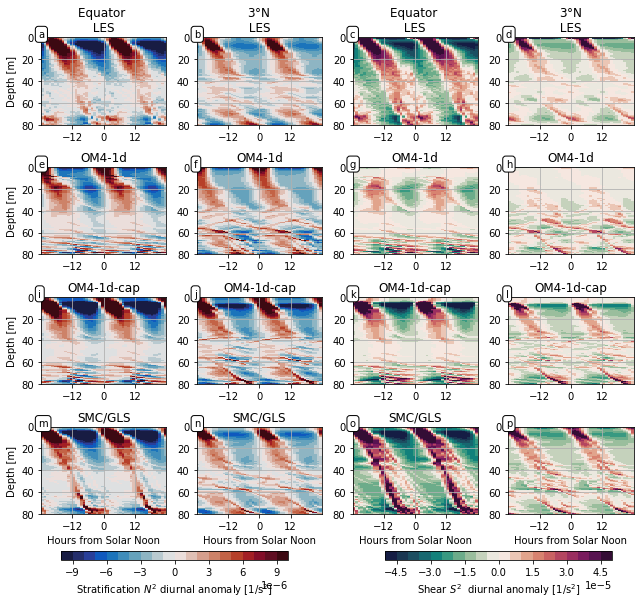

In [6]:
cmap1=cmocean.cm.curl
levels1=np.linspace(-5.e-5,5e-5,21)

cmap2=cmocean.cm.balance
levels2=np.linspace(-1.e-5,1e-5,21)

#Setting time w/ local noon referenced to zero
time=np.arange(24)+9.5
time[time>12]-=24
xi=np.argsort(time)


f,a=plt.subplots(4,4,figsize=(9,8))

LES_DAT=(LES0_1h.N2).values.astype(np.float64)
FLDdt = group_by_hour(LES_DAT,detrend=True)
fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[0]
C2=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                (np.concatenate((fld,fld,fld),axis=1)),
                cmap=cmap2,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('Equator \n LES ')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[4]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0_1.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[8]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')
ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM0_2.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[12]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hours from Solar Noon')


LES_DAT=(LES3_1h.N2).values.astype(np.float64)
FLDdt = group_by_hour(LES_DAT,detrend=True)
fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[1]
C1=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                (np.concatenate((fld,fld,fld),axis=1)),
                cmap=cmap2,
                norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('3$\degree$N \n LES ')

FLDdt = group_by_hour(MOM3.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[5]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')

FLDdt = group_by_hour(MOM3_1.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[9]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')
#ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour(MOM3_2.rhopot0.differentiate(coord='zl').values.astype(np.float64)*9.81/1025,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[13]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
#ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hours from Solar Noon')



LES_DAT=(LES0_1h.ume.differentiate(coord='z').values.astype(np.float64))**2+(LES0_1h.vme.differentiate(coord='z').values.astype(np.float64))**2
FLDdt = group_by_hour(LES_DAT,detrend=True)
fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[2]
C1=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                (np.concatenate((fld,fld,fld),axis=1)),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('Equator \n LES ')

FLDdt = group_by_hour((MOM0.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM0.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[6]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')

FLDdt = group_by_hour((MOM0_1.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM0_1.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[10]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')
#ax.set_ylabel('Depth [m]')

FLDdt = group_by_hour((MOM0_2.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM0_2.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[14]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('SMC/GLS')
#ax.set_ylabel('Depth [m]')
ax.set_xlabel('Hours from Solar Noon')


LES_DAT=(LES3_1h.ume.differentiate(coord='z').values.astype(np.float64))**2+(LES3_1h.vme.differentiate(coord='z').values.astype(np.float64))**2
FLDdt = group_by_hour(LES_DAT,detrend=True)
fld=(FLDdt-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[3]
C1=ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                -LES0_1h.z,
                (np.concatenate((fld,fld,fld),axis=1)),
                cmap=cmap1,
                norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
               )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('3$\degree$N \n LES ')

FLDdt = group_by_hour((MOM3.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM3.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[7]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d')

FLDdt = group_by_hour((MOM3_1.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM3_1.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[11]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_1.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_title('OM4-1d-cap')

FLDdt = group_by_hour((MOM3_2.uo.differentiate(coord='zl').values.astype(np.float64))**2+(MOM3_2.vo.differentiate(coord='zl').values.astype(np.float64))**2,detrend=True)
fld=(FLDdt[xi,:]-np.nanmean(FLDdt,axis=0)).T
ax=a.ravel()[15]
ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
               MOM0_2.zl,
               np.concatenate((fld,fld,fld),axis=1),
               cmap=cmap1,
               norm = mpl.colors.BoundaryNorm(levels1, ncolors=cmap2.N, clip=False)
              )
ax.set_xlim(-24,24)
ax.set_ylim(80,0)
ax.set_xticks([-12,0,12])
ax.grid(True)
ax.set_xlabel('Hours from Solar Noon')

f.tight_layout()

f.subplots_adjust(bottom=0.1)



cbar_ax = f.add_axes([0.1, 0.02, 0.35, 0.015])
cb=f.colorbar(C2, cax=cbar_ax,orientation='horizontal')
cb.set_label(r'Stratification $N^2$ diurnal anomaly [1/s$^2$]')

cbar_ax = f.add_axes([0.6, 0.02, 0.35, 0.015])
cb=f.colorbar(C1, cax=cbar_ax,orientation='horizontal')
cb.set_label(r'Shear $S^2$  diurnal anomaly [1/s$^2$]')

for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    a.ravel()[AXi].text(-25,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
    
f.savefig('../Fig/LES-MOM1d-N2_and_S2_diurnalcomposite.png',dpi=200,bbox_inches = "tight")